In [1]:
using Revise
using ObjectiveEmpiricalBayes
import ObjectiveEmpiricalBayes: OptConfig, Transformation, FEModel, generatedata, transformmodel, 
    ReferenceRegularizer, ThikonovRegularizer, cvscore, ebprior, compareplot, likelihoodmat

using Random: seed!
using Distributions
using PyPlot
using CSV
using LinearAlgebra
linspace(x...) = LinRange(x...) |> collect
midpoints(min, max, n) = [min + (max-min) / n * (i-1/2) for i=1:n]

OPTCONFIG=OptConfig(XTOLABS=1e-8, DEBUG=true);

In [2]:
table = CSV.read("baseballdata.csv")

,FirstName,LastName,At-Bats,Hits,BattingAverage,RemainingAt-Bats,RemainingHits
,String,String,Int64,Int64,Float64,Int64,Int64
1,Roberto,Clemente,45,18,0.4,367,127
2,Frank,Robinson,45,17,0.378,426,127
3,Frank,Howard,45,16,0.356,521,144
4,Jay,Johnstone,45,15,0.333,275,61
5,Ken,Berry,45,14,0.311,418,114
6,Jim,Spencer,45,14,0.311,466,126
7,Don,Kessinger,45,13,0.289,586,155
8,Luis,Alvarado,45,12,0.267,138,29
9,Ron,Santo,45,11,0.244,510,137


In [3]:
xs = midpoints(0.1, 0.5, 300)

data = table[:,:BattingAverage]
M = length(data)
N = 45
σ = sqrt(mean(data) * (1 - mean(data)) / N)

0.06582090626055082

In [4]:
# cross validation routine
function cverp(m, data; ncv=10, rs = linspace(0.01,0.1,ncv))
    regs = [ReferenceRegularizer(m, r) for r in rs]
    @time ss = [cvscore(m, data, dd->ebprior(m, dd, r, OPTCONFIG)) for r in regs]
    @show reg = rs[argmax(ss)]
    plot(rs, ss)
    ebprior(m,  data, ReferenceRegularizer(m,  reg), OPTCONFIG), reg
end

cverp (generic function with 1 method)

In [5]:
B = 1 - (M - 3) * σ^2 / sum((data .- mean(data)).^2)
μ_js = mean(data)
σ_js = sqrt(B * σ^2 / (1 - B))

w_js = normalize(pdf.(Normal(μ_js, σ_js), xs), 1);

  8.780352 seconds (9.22 M allocations: 48.909 GiB, 16.85% gc time)


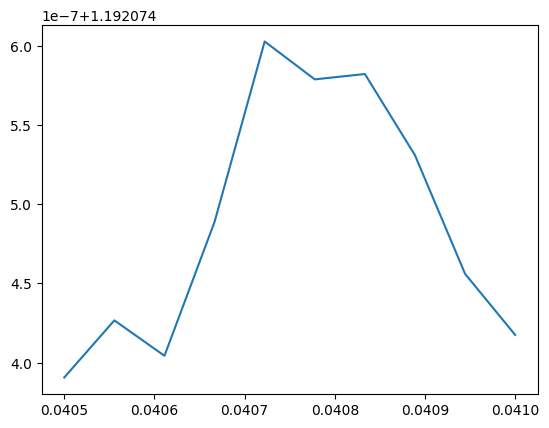

reg = rs[argmax(ss)] = 0.04072222222222223


([3.2573534108462623e-10, 3.956441340635696e-10, 4.818272015384601e-10, 5.883052974804293e-10, 7.201380140673554e-10, 8.837017278978903e-10, 1.0870427100794847e-9, 1.340327723471331e-9, 1.6564183167364039e-9, 2.0516041217214753e-9  …  2.9620359084300694e-11, 2.5372121003846573e-11, 2.1799720662031943e-11, 1.8787817623695064e-11, 1.624186963353596e-11, 1.4084214567259199e-11, 1.2250807718179943e-11, 1.0688905690906795e-11, 9.354811662018263e-12, 8.21230450985971e-12], 0.04072222222222223)

In [6]:
m = FEModel(f=x->x, xs=xs, σ=σ)

w_er, reg = cverp(m, data, rs = linspace(0.0405,0.041,10))

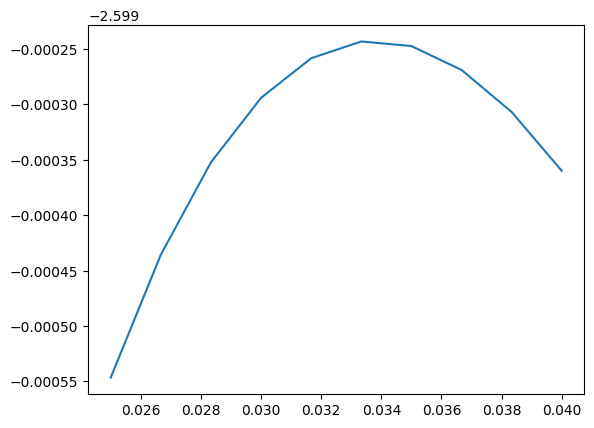

  8.141095 seconds (3.47 M allocations: 53.394 GiB, 21.28% gc time)
reg = rs[argmax(ss)] = 0.03333333333333333


([3.641203019716438e-13, 4.746004485393323e-13, 6.29831541672653e-13, 8.397010547632905e-13, 1.1060077968249284e-12, 1.4564420659338131e-12, 1.957529091080717e-12, 2.641003951910239e-12, 3.5836950603491512e-12, 4.88521947501143e-12  …  1.4100074635554567e-12, 1.1785714271094462e-12, 9.90820503107911e-13, 8.272474321451394e-13, 6.874525337536933e-13, 5.713495769312758e-13, 4.770523038652454e-13, 4.0143634486487525e-13, 3.41075042141489e-13, 2.9282524096271865e-13], 0.03333333333333333)

In [7]:
# TODO: Binomial Model

m_bin = ObjectiveEmpiricalBayes.BinomialModel(N, xs)
reg_bin = 0

data_bin = round.(Int, data * N)
w_bin, reg = cverp(m_bin, data_bin, rs = linspace(0.025,0.04,10))

#figure()
#plot(xs, w_bin)

In [8]:
function posteriors(w)
    L=likelihoodmat(m, data)
    post = w .* L'
    post = post ./ sum(post, dims=1)
end

posteriormeans(w) = posteriors(w)' * xs

truth = table[:, :RemainingHits] ./ table[:, Symbol("RemainingAt-Bats")]

function errors(w)
    posteriormeans(w) - truth
end

mse(w) = mean(x->x^2, errors(w))

mse (generic function with 1 method)

In [9]:
# compute the individual posteriors
posts = hcat((posteriormeans(w) for w in [w_js, w_er, w_bin])...)

18×3 Array{Float64,2}:
 0.293979  0.303475  0.298279
 0.289306  0.296413  0.292434
 0.284634  0.28936   0.286573
 0.279749  0.28217   0.280531
 0.275076  0.275612  0.274927
 0.275076  0.275612  0.274927
 0.270404  0.269464  0.269568
 0.265731  0.263779  0.264508
 0.260846  0.258345  0.259569
 0.260846  0.258345  0.259569
 0.256174  0.253613  0.255189
 0.256174  0.253613  0.255189
 0.256174  0.253613  0.255189
 0.256174  0.253613  0.255189
 0.256174  0.253613  0.255189
 0.251501  0.249297  0.25114 
 0.246828  0.245349  0.247401
 0.242156  0.241719  0.243946

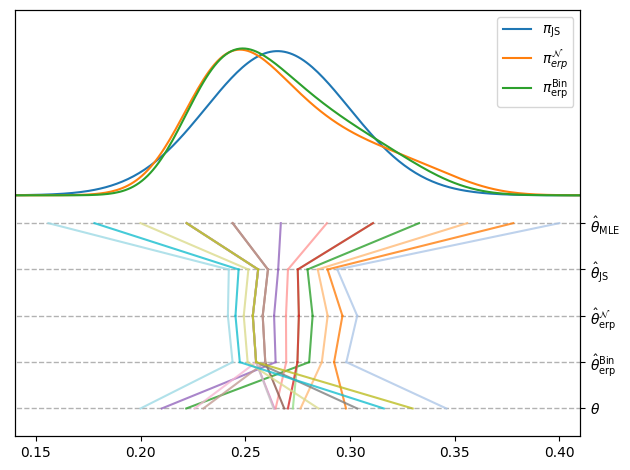

In [10]:
fig, ax1 = subplots()

xmin, xmax = .14, .41
ymin, ymax = -0.026, 0.02

plot(xs, w_js, label="\$\\pi_{\\rm JS}\$")
plot(xs, w_er, label="\$\\pi^{\\mathcal{N}}_{erp}\$")
plot(xs, w_bin, label="\$\\pi^{\\rmBin}_{\\rmerp}\$")
legend()

#grid(which="major",axis="both", alpha=0.2)

xlim(xmin, xmax)
ylim(ymin, ymax)
ax1.set_yticks([])

#subplot(212, sharex=ax1)
offset = -0.003
scale=-5e-3

dots = hcat(data, posts, truth)
scale = scale=-5e-3

yt = vcat([0,1,2,3,4] .* scale.+offset)
ytl = vcat(["\$\\hat\\theta_{\\rmMLE}\$",
        "\$\\hat\\theta_{\\rmJS}\$", 
        "\$\\hat\\theta_{\\rmerp}^{\\mathcal{N}}\$", 
        "\$\\hat\\theta_{\\rmerp}^{\\rmBin}\$", 
        "\$\\theta\$"])

ax2 = ax1.twinx()
#ax2.yaxis.set_label_position("right")


ax2.set_ylim(ymin , ymax)
ax2.set_yticks(yt)
ax2.set_yticklabels(ytl)

ax2.hlines([0,1,2,3,4] .* scale.+offset, 0, 1, linewidth=1, alpha=0.3, linestyle="dashed")

for i=1:size(dots, 1)
    for j=1:size(dots, 2)-1
        ax2.plot([dots[i,j], dots[i,j+1]], [j-1,j].*scale.+offset, alpha=0.8, c=PyPlot.cm.tab20(i/18))
    end
end
fig.tight_layout()
savefig("baseball.pdf", bbox_inches="tight")

In [11]:
# compute mean squared errors
mse_ml = mean(x->x^2, data - truth)
@show mse_ml
@show mse(w_js) / mse_ml
@show mse(w_er) / mse_ml
@show mse(w_bin) / mse_ml

mse_ml = 0.004764985095190408
mse(w_js) / mse_ml = 0.31242256652523565
mse(w_er) / mse_ml = 0.3123379695680969
mse(w_bin) / mse_ml = 0.30966519093466754


0.30966519093466754

In [12]:
# print results in latex table
using Printf
spf(x) = Printf.@sprintf("%.3f", x)

function latex_table()
    digits = 3
    let posts = round.(posts, digits=digits), 
        data = round.(data, digits=digits),
        truth = round.(truth, digits=digits)
    for i=1:18
        if i%2 == 1
            println("\\rowcolor{black!20}")
            end
        println("$(table[i,2]) & " *
            "\$$(spf(data[i])) = \\nicefrac{$(table[i,4])}{45}\$ & " *
            "\$$(spf(posts[i,1])) \$& \$$(spf(posts[i,2]))\$ & \$$(spf(posts[i,3]))\$ & " *
            "\$$(truth[i]) = \\nicefrac{$(table[i,7])}{$(table[i,6])} &" *
            "\\\\"
            )
    end
    end
end
latex_table()

\rowcolor{black!20}
Clemente & $0.400 = \nicefrac{18}{45}$ & $0.294 $& $0.303$ & $0.298$ & $0.346 = \nicefrac{127}{367} &\\
Robinson & $0.378 = \nicefrac{17}{45}$ & $0.289 $& $0.296$ & $0.292$ & $0.298 = \nicefrac{127}{426} &\\
\rowcolor{black!20}
Howard & $0.356 = \nicefrac{16}{45}$ & $0.285 $& $0.289$ & $0.287$ & $0.276 = \nicefrac{144}{521} &\\
Johnstone & $0.333 = \nicefrac{15}{45}$ & $0.280 $& $0.282$ & $0.281$ & $0.222 = \nicefrac{61}{275} &\\
\rowcolor{black!20}
Berry & $0.311 = \nicefrac{14}{45}$ & $0.275 $& $0.276$ & $0.275$ & $0.273 = \nicefrac{114}{418} &\\
Spencer & $0.311 = \nicefrac{14}{45}$ & $0.275 $& $0.276$ & $0.275$ & $0.27 = \nicefrac{126}{466} &\\
\rowcolor{black!20}
Kessinger & $0.289 = \nicefrac{13}{45}$ & $0.270 $& $0.269$ & $0.270$ & $0.265 = \nicefrac{155}{586} &\\
Alvarado & $0.267 = \nicefrac{12}{45}$ & $0.266 $& $0.264$ & $0.265$ & $0.21 = \nicefrac{29}{138} &\\
\rowcolor{black!20}
Santo & $0.244 = \nicefrac{11}{45}$ & $0.261 $& $0.258$ & $0.260$ & $0.269 =